In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

random.seed(1)# setting random seed
main_data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

2023-05-09 16:47:08.556246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# main_data['patientID'].value_counts()

In [3]:
cancerTypes = ['epithelial', 'inflammatory', 'fibroblast', 'others']
cancerous = ["Y", "N"]

one_hot = pd.get_dummies(main_data['cellTypeName'])
main_data = main_data.drop('cellTypeName',axis = 1)
main_data = main_data.join(one_hot)

# one_hot = pd.get_dummies(main_data['isCancerous'])
# main_data = main_data.drop('isCancerous',axis = 1)
# main_data = main_data.join(one_hot)
main_data
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

,InstanceID,patientID,ImageName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
0,22405,1,22405.png,0,0,0,1,0,0
1,22406,1,22406.png,0,0,0,1,0,0
2,22407,1,22407.png,0,0,0,1,0,0
3,22408,1,22408.png,0,0,0,1,0,0
4,22409,1,22409.png,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,2,1,1,0,0,0
9892,1626,60,1626.png,2,1,1,0,0,0
9893,1627,60,1627.png,2,1,1,0,0,0
9894,1628,60,1628.png,2,1,1,0,0,0


In [4]:
main_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellType        0
isCancerous     0
epithelial      0
fibroblast      0
inflammatory    0
others          0
dtype: int64

In [5]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(n_splits=5, random_state=42)
split = splitter.split(main_data, groups=main_data['patientID'])
splitter.get_n_splits()

5

In [6]:
gs_1 = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_test_ix, val_ix = next(gs_1.split(main_data, groups=main_data["patientID"]))
train_test = main_data.loc[train_test_ix]
val = main_data.loc[val_ix]

train_test = train_test.reset_index(drop=True)
gs_2 = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
train_ix, test_ix = next(gs_2.split(train_test, groups=train_test["patientID"]))
train = train_test.loc[train_ix]
test = train_test.loc[test_ix]

# https://stackoverflow.com/questions/68152473/python-split-to-train-test-val-using-groupshufflesplit

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

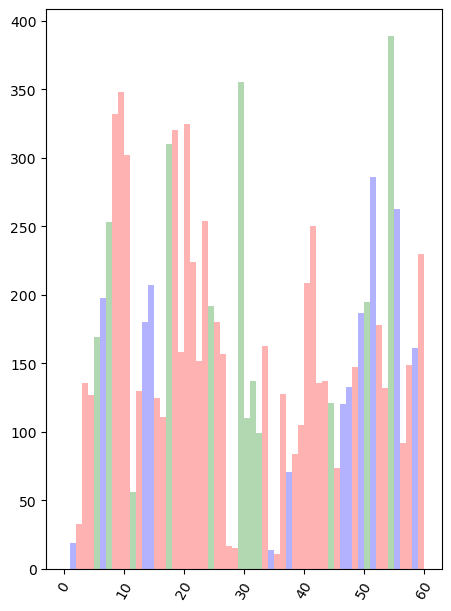

In [7]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.tight_layout(pad=4.0)
plt.hist(x=train['patientID'], alpha=0.3, color='r', bins=60,range=(0,60))
plt.hist(x=val['patientID'], alpha=0.3, color='b', bins=60, range=(0,60))
plt.hist(x=test['patientID'], alpha=0.3, color='g', bins=60, range=(0,60))
plt.xticks(rotation=60)

In [40]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
EPOCHS = 32

In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train['isCancerous'] = train['isCancerous'].astype('str')
val['isCancerous'] = val['isCancerous'].astype('str')
test['isCancerous'] = test['isCancerous'].astype('str')

train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = val_gen.flow_from_dataframe(
        dataframe=val,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_generator = test_gen.flow_from_dataframe(
        dataframe=test,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=1,
        class_mode='binary')

Found 5671 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.
Found 2386 validated image filenames belonging to 2 classes.


## Baseline

In [11]:
model = tf.keras.Sequential([
    layers.Flatten(input_shape=INPUT_DIM),
    layers.Dense(OUTPUT_CLASSES, activation="sigmoid")
])

2023-05-09 16:47:12.763947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 1)                 2188      
                                                                 
Total params: 2,188
Trainable params: 2,188
Non-trainable params: 0
_________________________________________________________________


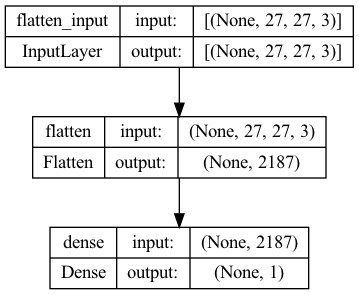

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01)
model.compile(optimizer = opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), f1_m,precision_m, recall_m])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS, verbose=0)

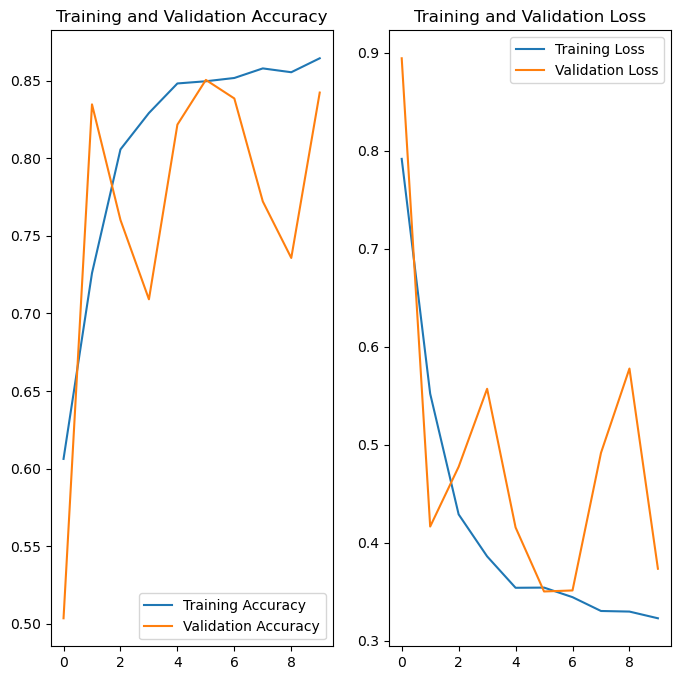

In [15]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CNN

In [16]:
# model = tf.keras.Sequential([
#   layers.Rescaling(1./255, input_shape=(27, 27, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128),
#   layers.Dense(OUTPUT_CLASSES, activation="sigmoid")
# ])
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = tf.keras.Sequential()
model.add(Conv2D(36, (3, 3), activation='relu', input_shape=(27, 27, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 36)        1008      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 36)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        15600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 512)         221696    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 512)       

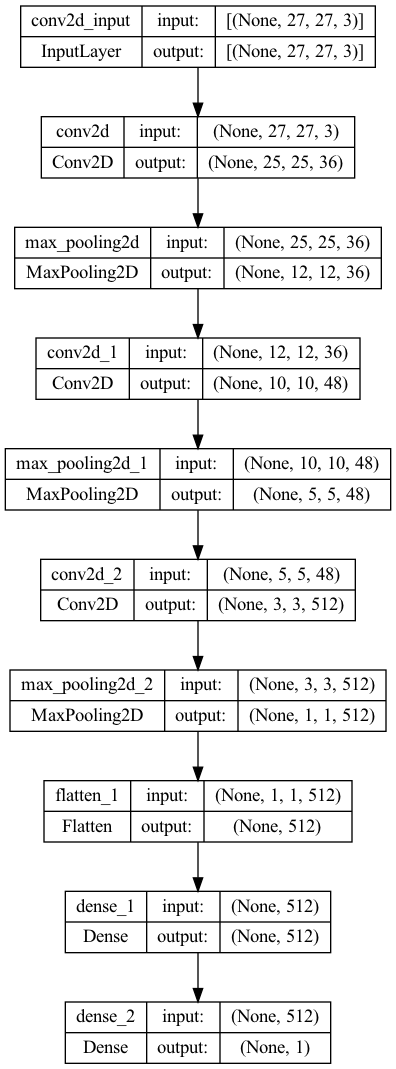

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/10
178/178 [==============================] - 5s 27ms/step - loss: 0.4492 - binary_accuracy: 0.7796 - val_loss: 0.5890 - val_binary_accuracy: 0.7858
Epoch 2/10
178/178 [==============================] - 6s 31ms/step - loss: 0.3097 - binary_accuracy: 0.8706 - val_loss: 0.3856 - val_binary_accuracy: 0.8352
Epoch 3/10
178/178 [==============================] - 5s 28ms/step - loss: 0.2886 - binary_accuracy: 0.8820 - val_loss: 0.3552 - val_binary_accuracy: 0.8434
Epoch 4/10
178/178 [==============================] - 5s 28ms/step - loss: 0.2779 - binary_accuracy: 0.8866 - val_loss: 0.3444 - val_binary_accuracy: 0.8477
Epoch 5/10
178/178 [==============================] - 5s 29ms/step - loss: 0.2694 - binary_accuracy: 0.8903 - val_loss: 0.4096 - val_binary_accuracy: 0.8184
Epoch 6/10
178/178 [==============================] - 4s 25ms/step - loss: 0.2568 - binary_accuracy: 0.8946 - val_loss: 0.3757 - val_binary_accuracy: 0.8293
Epoch 7/10
178/178 [==============================] - 4s 2

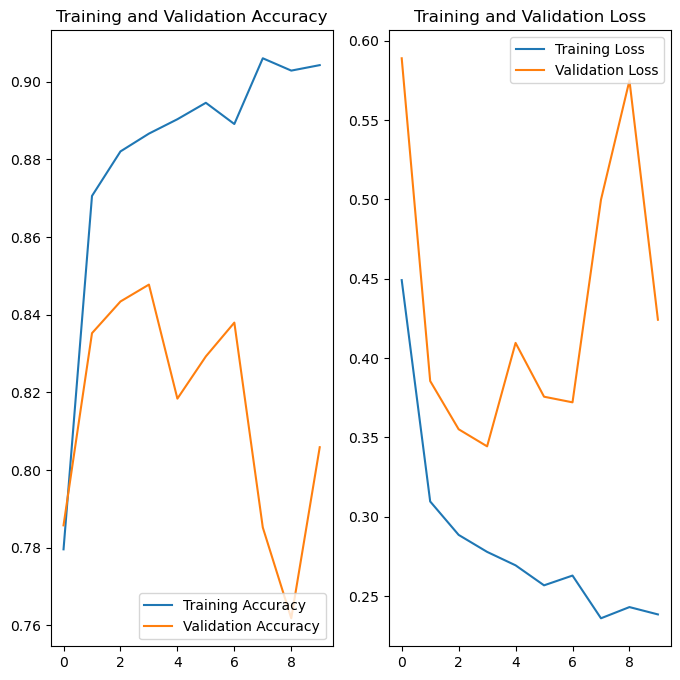

In [20]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

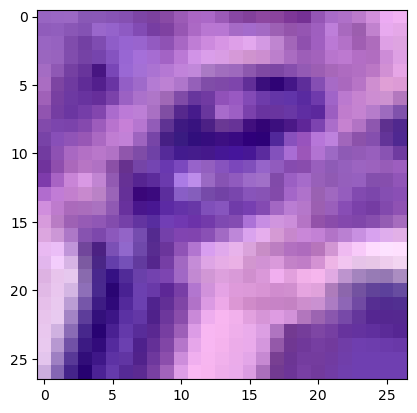

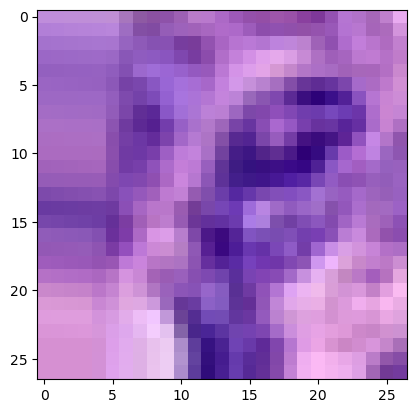

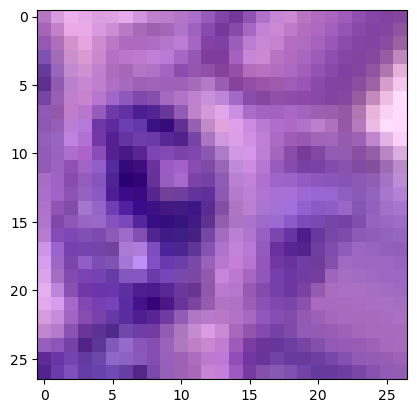

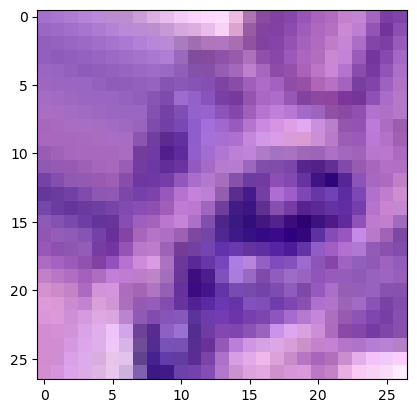

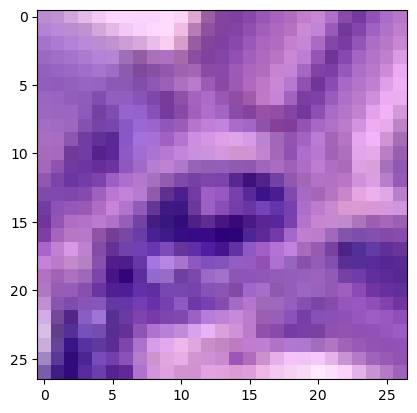

In [21]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join("./Image_classification_data/patch_images", os.listdir("./Image_classification_data/patch_images")[2])
img = load_img(img_path, target_size=(27, 27))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

In [37]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               data_format='channels_last')

train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 5671 validated image filenames belonging to 2 classes.


In [38]:
model.compile(optimizer = 'adam',
# from keras.optimizers import SGD
# opt = SGD(learning_rate=0.001)
# model.compile(optimizer = opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/10
23/23 [==============================] - 7s 301ms/step - loss: 0.2689 - binary_accuracy: 0.8907 - val_loss: 0.3865 - val_binary_accuracy: 0.8390
Epoch 2/10
23/23 [==============================] - 7s 289ms/step - loss: 0.2484 - binary_accuracy: 0.8983 - val_loss: 0.4268 - val_binary_accuracy: 0.8282
Epoch 3/10
23/23 [==============================] - 6s 270ms/step - loss: 0.2409 - binary_accuracy: 0.9013 - val_loss: 0.4017 - val_binary_accuracy: 0.8374
Epoch 4/10
23/23 [==============================] - 6s 258ms/step - loss: 0.2374 - binary_accuracy: 0.9018 - val_loss: 0.4441 - val_binary_accuracy: 0.8276
Epoch 5/10
23/23 [==============================] - 7s 283ms/step - loss: 0.2425 - binary_accuracy: 0.8997 - val_loss: 0.4843 - val_binary_accuracy: 0.7999
Epoch 6/10
23/23 [==============================] - 6s 254ms/step - loss: 0.2446 - binary_accuracy: 0.9005 - val_loss: 0.4780 - val_binary_accuracy: 0.7934
Epoch 7/10
23/23 [==============================] - 6s 254ms/ste

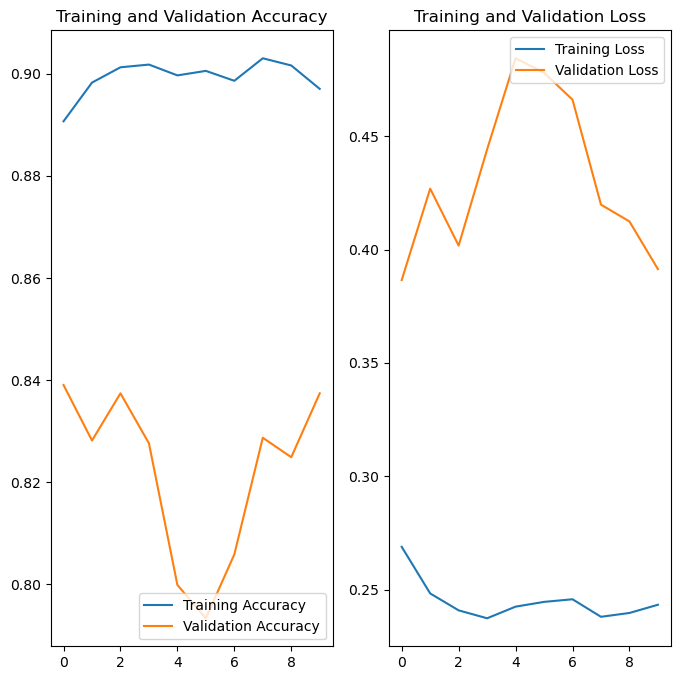

In [39]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing

In [26]:
results=model.evaluate(test_generator)
print("Loss: {}".format(round(results[0], 3)))
print("Accuracy: {}".format(round(results[1], 3)))
# print("F1 Score: {}".format(round(results[2], 3)))
# print("Precision Score: {}".format(round(results[3], 3)))
# print("Recall Score: {}".format(round(results[4], 3)))

2386/2386 [==============================] - 3s 1ms/step - loss: 0.3522 - binary_accuracy: 0.8487
Loss: 0.352
Accuracy: 0.849
